### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

import lightgbm
import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# My functions 
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'br_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory created!
Directory created!


In [4]:
for i in ['RandomForest', 'SVM_rbf', 'SVM_poly', 'LightGBM', 'XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!
Directory created!
Directory created!
Directory created!


In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
####   Separated df between train and test (25%)
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})

In [7]:
# Bayesian Ridge Imputation
imputer = IterativeImputer(estimator=BayesianRidge(n_iter=1000))
imputer = imputer.fit(data)
data = pd.DataFrame(imputer.transform(data), columns=data.columns, index=data.index)
unseen_data = pd.DataFrame(imputer.transform(unseen_data), columns=unseen_data.columns, index=unseen_data.index)

### Tiramos contry of residence y nationality
data.drop(['nationality', 'country_of_residence'], axis=1, inplace=True)
unseen_data.drop(['nationality', 'country_of_residence'], axis=1, inplace=True)

In [8]:
print(data.shape, unseen_data.shape)
print(data.isna().sum().sum(), unseen_data.isna().sum().sum())

(974, 40) (107, 40)
0 0


In [9]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh


In [10]:
print(f"Data to Train: {len(data)}\Out of sample data: {len(unseen_data)}")

Data to Train: 974\Out of sample data: 107


In [11]:
### Load Hyperparams
# hparams_path = "/home/mm/Tesis/pred_results/2023-07-14/mean_hparams/" # ssh

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-07-15/mean_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

rbf_hp = pd.read_csv(hparams_path + "SVC_RBF_hparams2.csv",
                     usecols=['param_C', 'param_gamma','params', 'mean_test_score' ,'mean_train_score'])
rbf_hp= rbf_hp[rbf_hp['mean_test_score'] < rbf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

poly_hp = pd.read_csv(hparams_path + "SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

lgbm_hp = pd.read_csv(hparams_path + "lgbm_hparams.csv", usecols=[ 'param_learning_rate', 'param_max_depth',
       'param_n_estimators', 'param_num_leaves', 'param_reg_alpha',
       'param_reg_lambda','params', 'mean_test_score' ,'mean_train_score'])
lgbm_hp= lgbm_hp[lgbm_hp['mean_test_score'] < lgbm_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

xgb_hp = pd.read_csv(hparams_path + "xgb_hparams.csv", usecols=['param_booster', 'param_learning_rate',
       'param_max_bin', 'param_max_depth', 'param_max_leaves',
       'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
       'param_tree_method','params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head()

In [12]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[0,'param_n_estimators'],
    "criterion": rf_hp.loc[0,'param_criterion'],
    "max_depth": rf_hp.loc[0,'param_max_depth'],
    "min_samples_split": rf_hp.loc[0,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[0,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[0,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}
#RBF
rbf_params = {'C': rbf_hp.loc[0, "param_C"],
              'gamma': rbf_hp.loc[0, "param_gamma"],
              "kernel":"rbf","class_weight":"balanced", "verbose":0}
#Poly
poly_params = {'C': poly_hp.loc[0, "param_C"],
              'gamma': poly_hp.loc[0, "param_gamma"],
               'coef0': poly_hp.loc[0, "param_coef0"],
               'degree': poly_hp.loc[0, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0}
#LGBM
lgbm_params ={'num_leaves': lgbm_hp.loc[0, 'param_num_leaves'],
    'max_depth': lgbm_hp.loc[0, 'param_max_depth'],
    'learning_rate':lgbm_hp.loc[0, 'param_learning_rate'],
    'n_estimators': lgbm_hp.loc[0, 'param_n_estimators'],
    'reg_alpha':lgbm_hp.loc[0, 'param_reg_alpha'],
    'reg_lambda':lgbm_hp.loc[0, 'param_reg_lambda'],
    'subsample':1.0,
    'subsample_freq':-1,
    'objective':'binary',
    'n_jobs': -1,
    'verbose':-1}

#XGBOOST
xgb_params = {
    'booster': xgb_hp.loc[0, 'param_booster'],
    'tree_method': xgb_hp.loc[0, 'param_tree_method'],
    'max_leaves': xgb_hp.loc[0, 'param_max_leaves'],
    'max_depth': xgb_hp.loc[0, 'param_max_depth'],
    'max_bin': xgb_hp.loc[0, 'param_max_bin'],
    'learning_rate': xgb_hp.loc[0, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[0, 'param_n_estimators'],
    'reg_alpha': xgb_hp.loc[0, 'param_reg_alpha'],
    'reg_lambda': xgb_hp.loc[0, 'param_reg_lambda'],
    'gamma': 0.005,
    'subsample':1.0,
    'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

### RF Model

##### Bootstrap

In [14]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=10, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=14, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=500, n_jobs=-1)


Iterating: 100%|██████████████████████| 10/10 [00:10<00:00,  1.02s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:0.16956502199172974 minutes
empirical p-value: 0.0


In [15]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-08-20/br_res'

In [ ]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res.csv", index=False)
Model_res.mean()

In [ ]:
print("%.4f" % Model_res['ROC_AUC'].mean())


In [ ]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df.csv", index=False)
CI_df

In [ ]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

In [ ]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve.png")
# Fig save?


In [ ]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM.png")

##### Permutation Feature importance

In [ ]:
rf_fimp = bc.permutation_FIMP( data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.3, n_repeats=1000, random_state=123)

In [ ]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
rf_fimp.sort_values('mean', ascending=False).head()

In [ ]:
# ml_plotting.plot_permutation_FIMP(rf_fimp, names='variables', importances_col='Importance_mean', std_col='Importance_std')

In [ ]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

##### unseen data

In [16]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [17]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

/tmp/ipykernel_1172681/2748179169.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


In [24]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.Explainer(rfc)
shap_values = explainer.shap_values(X_test)


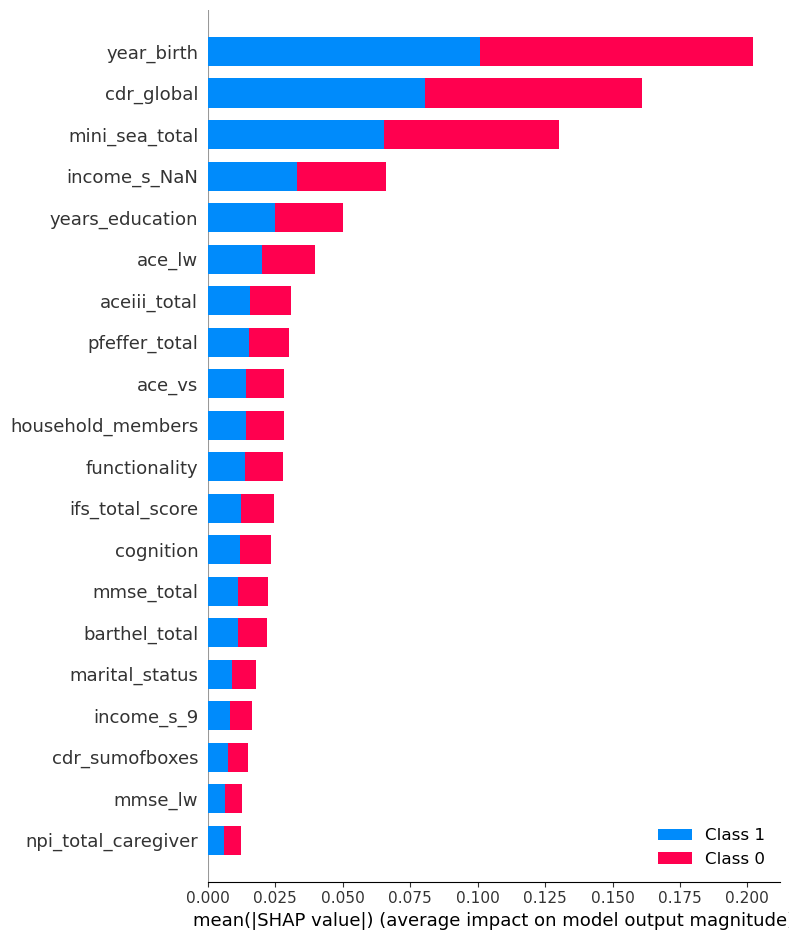

In [25]:
# Plot the SHAP values for a single prediction
shap.summary_plot(shap_values, X_test)



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


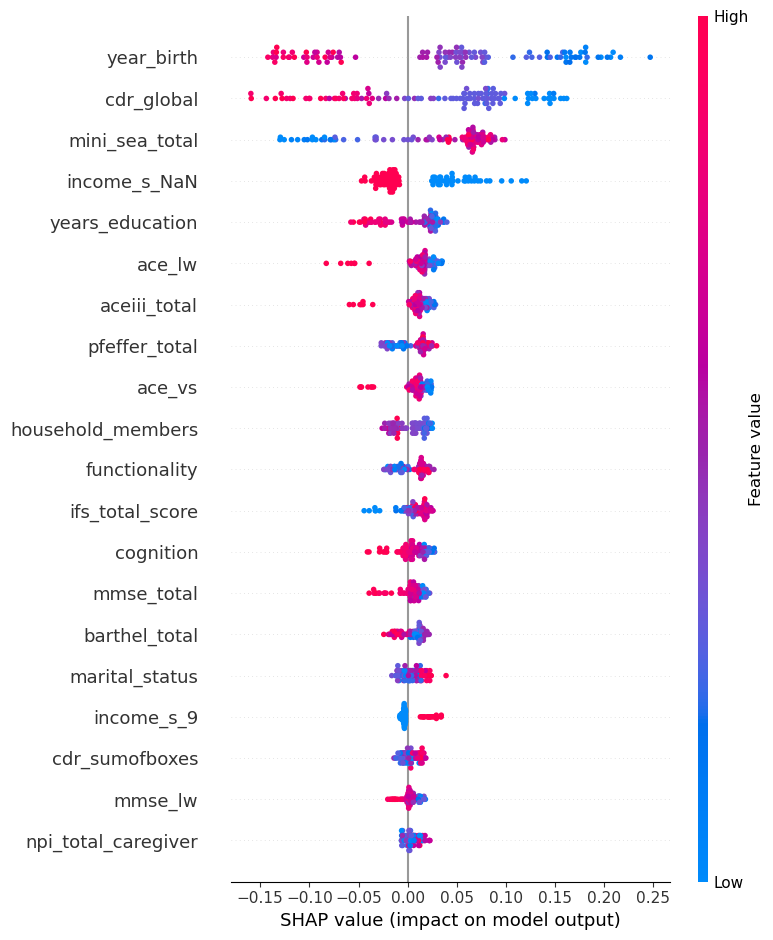

In [26]:
shap.summary_plot(shap_values[0], X_test)



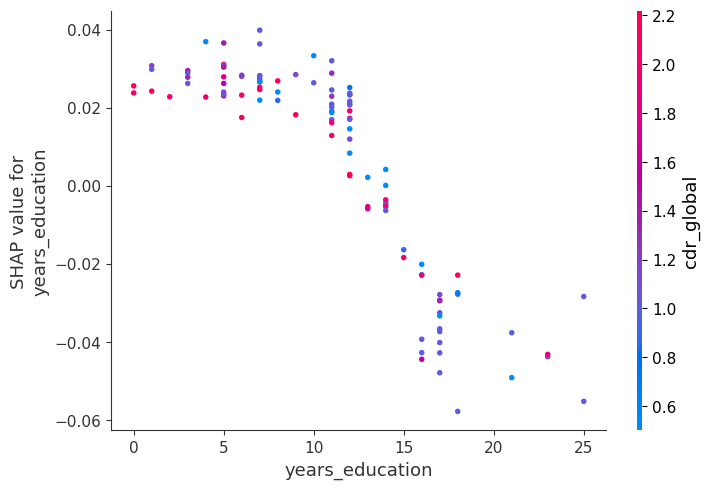

In [29]:
shap.dependence_plot("years_education", shap_values[0], X_test,interaction_index="cdr_global")

In [ ]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [ ]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

In [ ]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

In [ ]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])

### SVM - RBF

##### Bootstrap

In [ ]:
rbf_Model_res, rbf_CI_df, rbf_Model_res_r, rbf_ROC_AUC, rbf_CM, rbf_ROC_chance, rbf_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=rbf_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

In [ ]:
rbf_Model_res.to_csv(path_res+ "/SVM_rbf/rbf_Model_res.csv", index=False)
rbf_Model_res.mean()

In [ ]:
rbf_CI_df.to_csv(path_res+ "/SVM_rbf/rbf_CI_df.csv", index=False)
rbf_CI_df

In [ ]:
rbf_Model_res_r

In [ ]:
ml_plotting.plot_custom_roc_curve(rbf_ROC_AUC, rbf_ROC_chance, fname=path_res+ "/SVM_rbf/rbf_ROC_AUC_curve.png")

In [ ]:
ml_plotting.plot_boostrap_CM(rbf_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_rbf/rbf_CM.png")

#### Permutation Feature importance

In [ ]:
rbf_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=rbf_params, test_size=.3, n_repeats=1000, random_state=123)

In [ ]:
rbf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_rbf/rbf_PFI.csv")
rbf_fimp.sort_values('mean', ascending=False)

#### Unseen data

In [ ]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [ ]:
#Predict
svc_rbf = SVC(**rbf_params)
svc_rbf.fit(X_train, y_train)
y_pred = svc_rbf.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

In [ ]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/SVM_rbf/rbf_unseen.csv")

In [ ]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{rbf_Model_res['ROC_AUC'].mean():.4f}")

### SVM - Poly

#### Bootstrap

In [ ]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

In [ ]:
p_Model_res.to_csv(path_res+ "/SVM_poly/poly_Model_res.csv", index=False)
p_Model_res.mean()

In [ ]:
p_CI_df.to_csv(path_res+ "/SVM_poly/poly_CI_df.csv", index=False)
p_CI_df.mean()

In [ ]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly/poly_ROC_AUC_curve.png")

In [ ]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_CM.png")

#### Permutation Feature importance

In [ ]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=1000, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly/poly_PFI.csv")
p_fimp.sort_values('mean', ascending=False)

#### Unseen data

In [ ]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [ ]:
poly = SVC(**poly_params)
poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

In [ ]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/SVM_poly/poly_PFI.csv")

In [ ]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

In [ ]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])

### LightGBM

#### Bootstrap

In [ ]:
lgb_Model_res, lgb_CI_df, lgb_Model_res_r, lgb_ROC_AUC, lgbCM, lgb_ROC_chance, lgb_empirical_p_value, _ = bc.Bootstrap_LGBM_classifier(
    data, 'diagnosis',  params=lgbm_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

In [ ]:
lgb_Model_res.to_csv(path_res+ "/LightGBM/lgb_Model_res.csv", index=False)
lgb_Model_res.mean()

In [ ]:
lgb_CI_df.to_csv(path_res+ "/LightGBM/lgb_CI_df.csv", index=False)
lgb_CI_df

In [ ]:
lgb_Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+"/LightGBM/lgb_CI_df.csv", index=False)
lgb_Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

In [ ]:
ml_plotting.plot_custom_roc_curve(lgb_ROC_AUC, lgb_ROC_chance, fname=path_res+ "/LightGBM/lgb_ROC.png")

In [ ]:
ml_plotting.plot_boostrap_CM(lgbCM, labels=['AD', 'FTD'],fname=path_res+ "/LightGBM/lgb_CM.png")

#### Permutation Feature importance

In [ ]:
lgb_fimp = bc.permutation_FIMP( data, 'diagnosis', lightgbm.LGBMClassifier(), params=lgbm_params, test_size=.3, n_repeats=1000, random_state=123)
lgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/LightGBM/lgb_PFI.csv")
lgb_fimp.sort_values('mean', ascending=False).head()

#### Unseen data

In [ ]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [ ]:
lgb = lightgbm.LGBMClassifier(**lgbm_params)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

In [ ]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/LightGBM/lgb_PFI.csv")

In [ ]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lgb_Model_res['ROC_AUC'].mean():.4f}")

In [ ]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])

### XGBoost

#### Bootstrap

In [ ]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

In [ ]:
xgb_Model_res.to_csv(path_res+ "/XGBoost/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

In [ ]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

In [ ]:
xgb_CI_df.to_csv(path_res+ "/XGBoost/xgb_CI_df.csv", index=False)
xgb_CI_df

In [ ]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost/xgb_ROC.png")

In [ ]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM.png")

#### Permutation Feature importance

In [ ]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost/xgb_PFI.csv")
xgb_fimp.sort_values('mean', ascending=False)

#### Unseen data

In [ ]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [ ]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

In [ ]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/XGBoost/xgb_PFI.csv")

In [ ]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

In [ ]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])